In [40]:
# general setup
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits
from astropy import units as u
import astropy.modeling


from scipy import stats
import scipy.optimize as opt
from scipy import integrate

import os

/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Data reduction

In [41]:
data_dir = os.path.join(os.getcwd(),'amanda_shak_andrew_lab3')

# list of stars to indicate each field
stars = ['atlas', 'hd23778', 'hd23479', 'alcyone', 'celaeno', 'merope', 'hd23511',  'electra']
exp_times = [30, 15, 10, 5, 1, 0.1] # list of exposure times
filters = ['B', 'V']

# template filenames for the exposures
light_fnames = os.path.join(data_dir, 'lab3_{}.{:08d}.FIT')
flat_fnames = os.path.join(data_dir, 'lab3_flats.{:08d}.FIT')
dark_fnames = os.path.join(data_dir, 'lab3_darks.{:08d}.DARK.FIT')

# dictionary containing lists of file numbers for the flats and darks
flat_idxs = {'V': range(10), 'B': range(20,30)} # keys are the filters
dark_idxs = {} # keys are the exposure time
for exp_time, i in zip(exp_times, range(0,31,5)):
    dark_idxs[exp_time] = range(i,i+5)


# dict to hold the file numbers correpsonding to each star
idxs = {}

idxs['atlas'] = {0.1: {'V': range(5), 'B': range(250,255)}, 
                 1: {'V': range(5,10), 'B': range(245,250)}, 
                 5: {'V': range(10,15), 'B': range(240,245)}}

idxs['hd23778'] = {1: {'V': range(15,20), 'B': range(235,240)}, 
                   5: {'V': range(20,25), 'B': range(230,235)}, 
                   30: {'V': range(25,30), 'B': range(225,230)}}

idxs['hd23479'] = {1: {'V': range(30,35), 'B': range(220,225)},
                  5: {'V': range(35,40), 'B': range(215,220)},
                  15: {'V': range(40,45), 'B': range(210,215)}}

idxs['alcyone'] = {0.1: {'V': range(45,50), 'B': range(205,210)},
                  1: {'V': range(50,55), 'B': range(200,205)},
                  10: {'V': range(55,60), 'B': range(195,200)}}

idxs['celaeno'] = {0.1: {'V': range(60,65), 'B': range(190,195)},
                  1: {'V': range(65,70), 'B': range(185,190)},
                  10: {'V': range(70,75), 'B': range(180,185)}}

idxs['merope'] = {0.1: {'V': range(75,80), 'B': range(175,180)},
                 1: {'V': range(80,85), 'B': range(170,175)},
                 10: {'V': range(85,90), 'B': range(165,170)},
                 30: {'V': range(95,100), 'B': range(160,165)}}

idxs['hd23511'] = {1: {'V': range(100,105), 'B': range(150,155)},
                  10: {'V': range(110,115), 'B': range(145,150)}}

idxs['electra'] = {1: {'V': range(115,120), 'B':range(140,145)},
                  10: {'V': range(120,125), 'B': range(135,140)},
                  30: {'V': range(125,130), 'B': range(130,135)}}

In [42]:
# load the darks into a dictionary with the exposure time as the keys
darks = {}
for exp_time in exp_times:
    darks[exp_time] = []
    for idx in dark_idxs[exp_time]:
        with fits.open(dark_fnames.format(idx)) as f:
            darks[exp_time].append(f[0].data)

In [43]:
# create the master darks, and place them in a dictionary, again with exposure time as the keys
master_darks = {}
for exp_time in exp_times:
    master_darks[exp_time] = np.median(np.array(darks[exp_time]), axis=0)

### Create the master dark and master flat

In [44]:
# load the flats into a dictionary, with the filter as the keys
flats = {}
for filt in filters:
    flats[filt] = []
    for idx in flat_idxs[filt]:
        with fits.open(flat_fnames.format(idx)) as f:
            flats[filt].append(f[0].data)

In [45]:
# create master flats, and again store them in a dictionary, with the filter as the keys
master_flats = {}
for filt in filters:
    master_flats[filt] = np.median(np.array(flats[filt]), axis=0)
    master_flats[filt] /= np.median(master_flats[filt]) # normalize the flat field

#### Look at counts in the master darks and master flats

exposure time = 30 s
median =  982.0
standard deviation =  104.82754676


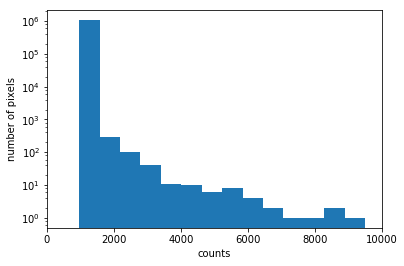

exposure time = 15 s
median =  980.0
standard deviation =  81.4681370504


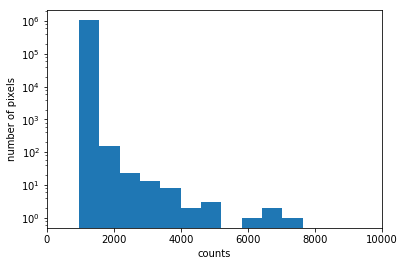

exposure time = 10 s
median =  979.0
standard deviation =  71.6106320222


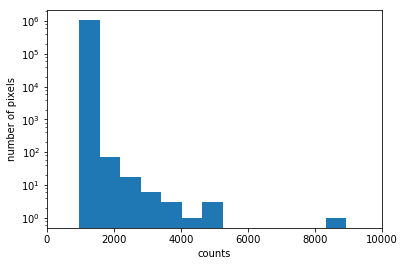

exposure time = 5 s
median =  978.0
standard deviation =  46.926477859


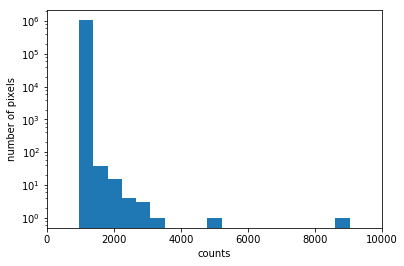

exposure time = 1 s
median =  978.0
standard deviation =  15.4020829494


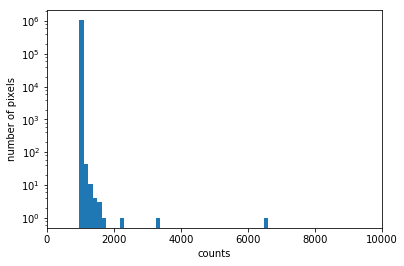

exposure time = 0.1 s
median =  978.0
standard deviation =  7.91932838841


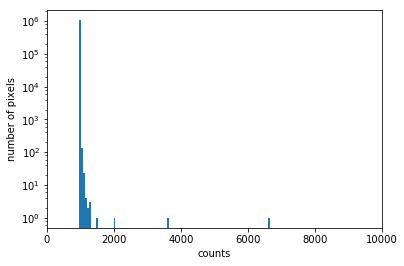

In [46]:
# make a histogram of the counts in the master dark for each exposure time
for exp_time in exp_times:
    print "exposure time = {} s".format(exp_time)
    print "median = ", np.median(master_darks[exp_time])
    print "standard deviation = ", np.std(master_darks[exp_time])
    plt.figure()
    plt.hist((master_darks[exp_time]).flatten(), bins=100)
    plt.xlabel("counts")
    plt.ylabel("number of pixels")
    plt.xlim([0,10000])
    plt.yscale('log')
    plt.show()

B
median =  1.0
standard deviation =  0.0213720574721


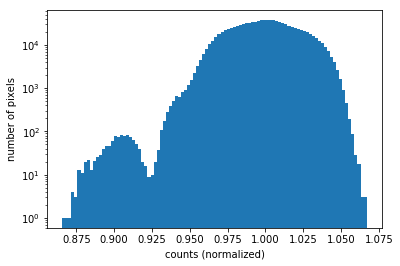

V
median =  1.0
standard deviation =  0.0206254770765


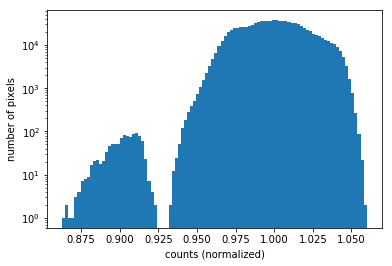

In [47]:
# make a histogram of the normalized counts in each master flat
for filt in filters:
    print filt
    print "median = ", np.median(master_flats[filt].flatten())
    print "standard deviation = ", np.std(master_flats[filt].flatten())
    plt.figure()
    plt.hist(master_flats[filt].flatten(), bins=100)
    plt.xlabel("counts (normalized)")
    plt.ylabel("number of pixels")
    plt.yscale('log')
    plt.show()

B


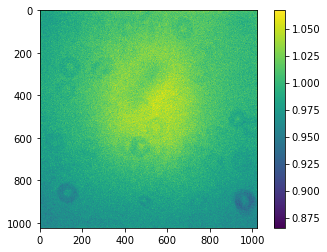

V


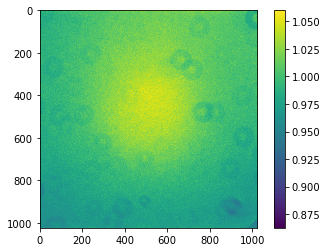

In [48]:
# look at the master flats
for filt in filters:
    print filt
    plt.figure()
    plt.imshow(master_flats[filt])
    plt.colorbar()
    plt.show()

### Make the bad pixel maps
(one for each exposure time and each filter)

In [49]:
def get_bad_pixel_map(dark, flat, nsigma_dark=5, nsigma_flat=5):
    """Returns a bad pixel map of the same size as the input dark and flat frames,
    with good pixels set to one and bad pixels are set to zero.
    Bad pixels are defined as any pixel in the dark frame that has a value of 
    nsigma_dark standard deviations above the average value of the dark frame,
    or any pixel in the flat field that has a value of nsigma_flat standard deviations
    abobe the average value of the flat field."""
    bad_pixel_map = np.ones(dark.shape) # create bad pixel map full of ones
    dark_avg = np.median(dark)
    dark_std = np.std(dark)
    flat_avg = np.median(flat)
    flat_std = np.std(flat)
    # loop through the pixels
    num_bad_pixels = 0
    for i in range(bad_pixel_map.shape[0]):
        for j in range(bad_pixel_map.shape[1]):
            # if the pixel is hot (greater than 5 standard deviations above the average 
            # in the master dark) or dead (more than 5 standard deviations below the
            # average in the master flat), then it is a bad pixel
            if (dark[i,j] > dark_avg + nsigma_dark * dark_std) or (flat[i,j] < flat_avg - nsigma_flat * flat_std):
                bad_pixel_map[i,j] = 0. # set the bad pixel to 0 in the bad pixel map
                num_bad_pixels += 1     # keep track of how many bad pixels there are 
    return bad_pixel_map, num_bad_pixels  

In [50]:
# will have a bad pixel map for each filter and each exposure time
bad_pixel_maps = {} # hold each in a dictionary

# loop through each filter and exposure time
for filt in filters:
    bad_pixel_maps[filt] = {}
    for exp_time in exp_times:
        bad_pixel_maps[filt][exp_time], num_bad_pixels = get_bad_pixel_map(master_darks[exp_time], 
                                                                           master_flats[filt], 
                                                                           nsigma_dark=5, 
                                                                           nsigma_flat=5)
        print "Filter = {}, exposure time = {} seconds, {} bad pixels, {:1.3f}% are bad".format(filt, exp_time, num_bad_pixels, 100 * num_bad_pixels / (1024.**2))


Filter = B, exposure time = 30 seconds, 730 bad pixels, 0.070% are bad
Filter = B, exposure time = 15 seconds, 550 bad pixels, 0.052% are bad
Filter = B, exposure time = 10 seconds, 441 bad pixels, 0.042% are bad
Filter = B, exposure time = 5 seconds, 364 bad pixels, 0.035% are bad
Filter = B, exposure time = 1 seconds, 338 bad pixels, 0.032% are bad
Filter = B, exposure time = 0.1 seconds, 344 bad pixels, 0.033% are bad
Filter = V, exposure time = 30 seconds, 819 bad pixels, 0.078% are bad
Filter = V, exposure time = 15 seconds, 639 bad pixels, 0.061% are bad
Filter = V, exposure time = 10 seconds, 530 bad pixels, 0.051% are bad
Filter = V, exposure time = 5 seconds, 453 bad pixels, 0.043% are bad
Filter = V, exposure time = 1 seconds, 427 bad pixels, 0.041% are bad
Filter = V, exposure time = 0.1 seconds, 433 bad pixels, 0.041% are bad


In [51]:
# save the bad pixel maps
bad_pixel_map_fname = 'data/bad_pixel_map_{}_{}s.fits'
for filt in filters:
    for exp_time in exp_times:
        bad_px_HDU = fits.PrimaryHDU(bad_pixel_maps[filt][exp_time])
        bad_px_HDU.writeto(bad_pixel_map_fname.format(filt,exp_time), overwrite=True)

### Load images, correct with darks and flats, and save them

In [52]:
data_fname = 'data/{}_{}_{}s_{:02d}.fits'  # template filename used to save the data
# loop through each star/frame, filter, and exposure time
for star in stars:
    for exp_time in idxs[star].keys():
        for filt in filters:
            for i, idx in enumerate(idxs[star][exp_time][filt]):
                # open the image 
                with fits.open(light_fnames.format(filt,idx)) as f:
                    img = f[0].data
                    header = f[0].header
                    img = img - master_darks[exp_time] # subtract master dark
                    img /= master_flats[filt] # divide by master flat
                # save the corrected image with its original header
                imgHDU = fits.PrimaryHDU(img, header=header)
                imgHDU.writeto(data_fname.format(star, filt, exp_time, i), overwrite=True)

## Astrometry.net

Create the bash script to run astrometry.net on each image.

First, create a list of the coordinates of the star that was centered in each frame:

In [33]:
def get_ra(hour, minutes, seconds):
    """Return the RA in degrees."""
    return hour * 15. + minutes * 0.25 + (15./3600.)*seconds

def get_dec(deg, arcmin, arcsec):
    """Return the dec in degrees."""
    return deg + (1./60.)*arcmin + (1./3600.)*arcsec

In [34]:
# actually, I already wrote them down in degrees ... 
# but the above functions will probably be useful later
ref_coords = {'atlas': (57.291, 24.053),
             'hd23479': (56.567, 24.190),
             'alcyone': (56.871, 24.105),
             'celaeno': (56.201, 24.289),
             'merope': (56.582, 23.948),
             'hd23511': (56.664, 24.103),
             'hd23778': (57.145, 24.181),
             'electra': (56.219, 24.113)}

Make the template for the bash script to run solve field and save one for each frame.

In [35]:
# create the text to save
astrometry_txt = "#! /bin/bash -u\n\n"
for star in stars:
    ra = ref_coords[star][0]
    dec = ref_coords[star][1]
    astrometry_txt += "for file in $(ls -1 data/{}*.fits)\n".format(star)
    astrometry_txt += "do\n"
    astrometry_txt += "\tsolve-field --ra " + str(ra) + " --dec " + str(dec) +" --radius 0.5 --scale-units degwidth --scale-low 0.25 --scale-high 1.0  ${file}\n" 
    astrometry_txt += "done\n\n"

# save it
with open('run_solve_field.sh', 'w') as f:
    f.write(astrometry_txt)

Choose the apertures to use with source extractor.

For very large stars, may want to choose a separate large aperture.

Note to self - may want to go back and choose a small , medium, and large aperture?    

In [36]:
# create a dictionary to hold the aperture for each star and exposure time
# the aperture should be the same for both filters
apertures = {}
large_apertures = {} # for very very bright stars



apertures['alcyone'] = {0.1: 2*19.0, 1: 2*13.5, 10:2*20.5}
large_apertures['alcyone'] = {1: 2*45.75}

apertures['atlas'] = {5: 2.*14.75, 1: 2*12.00, 0.1: 2*14.25}
large_apertures['atlas'] = {1: 2*26.25, 5: 2*58.5} # two larger stars

apertures['celaeno'] = {0.1: 2*16.0, 1: 2*13.75, 10: 2*15.5}
large_apertures['celaeno'] = {1: 2*21.75, 10: 2*21.5} 
# for 10 s, two largest stars are too saturated in B, and 3 largest are too saturated in V

apertures['electra'] = {1: 2*15.0, 10: 2*16.75, 30: 2*19.5}
large_apertures['electra'] = {1: 2*29.25, 10: 2*32.75}
# 10 s - brightest star is oversatured, 30 s - both are

apertures['hd23479'] = {1: 2*11.25, 5: 2*15.5, 15: 2*17.5}
large_apertures['hd23479'] = {1: 2*29.}
# too saturated above 1 s?

apertures['hd23511'] = {1: 2*13., 10: 2*17.25}
large_apertures['hd23511'] = {1: 2*36.5}
# too saturated above 1 s

apertures['hd23778'] = {1: 2*18., 5: 2*17.25, 30: 2*21.25}

apertures['merope'] = {0.1: 2*13., 1: 2*11., 10: 2*15.25, 30: 2*18.}
large_apertures['merope'] = {1: 2*23.}

Create the source extractor files with the given aperture

In [37]:
# want to change "phot_apertures" and "weight_image" in the default source extractor config file

def create_source_extractor_file(fname, aper, bad_px_map_fname):
    # open the default source extractor config file to use as a template
    default_se_fname = 'source_extractor/default.sex'
    with open(default_se_fname, 'r') as f:
        template = f.read()
    
    # look for the lines where we set 'PHOT_APERTURES' or 'WEIGHT_IMAGE',
    # and replace it with the appropriate setting
    lines = template.split("\n")
    for i, line in enumerate(lines):
        if 'PHOT_APERTURES' in line:
            line_items = line.split(" ")
            line_items[3] = str(aper)
            lines[i] = " ".join(line_items)
            
        if 'WEIGHT_IMAGE' in line:
            line_items = line.split(" ")
            line_items[-1] = bad_px_map_fname
            lines[i] = " ".join(line_items)
    
    # put everything back together and save it
    txt = "\n".join(lines)
    with open(fname, 'w') as f:
        f.write(txt)

In [56]:
source_extractor_fname_tmp = 'source_extractor/{}_{}_{}s.sex' # filename for the config file
source_extractor_large_ap_fname_tmp = 'source_extractor/{}_{}_{}s_large.sex'
bad_pixel_map_fname = 'data/bad_pixel_map_{}_{}s.fits' # filename for the bad pixel map used with the config file

# create a source extractor config file for each field, exposure time, and filter 
for star in stars:
    for exp_time in apertures[star].keys():
        for filt in filters:
            create_source_extractor_file(source_extractor_fname_tmp.format(star, filt, exp_time), 
                                         2*18., bad_pixel_map_fname.format(filt, exp_time))
            
            #if (star in large_apertures.keys()) and (exp_time in large_apertures[star].keys()):
            create_source_extractor_file(source_extractor_large_ap_fname_tmp.format(star, filt, exp_time), 
                                         120.,#large_apertures[star][exp_time], 
                                         bad_pixel_map_fname.format(filt, exp_time))
